# Preprocess

## Data Load

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import json
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import cv2
import pandas as pd
from matplotlib.colors import ListedColormap

In [72]:
TRAIN_JSON_PATH = '/content/drive/MyDrive/Final/Data/label/train/'
VALID_JSON_PATH = '/content/drive/MyDrive/Final/Data/label/val/'

TRAIN_IMG_PATH = '/content/drive/MyDrive/Final/Data/img/train/'
VALID_IMG_PATH = '/content/drive/MyDrive/Final/Data/label/val/'

TRAIN_SEGMENT_PATH = '/content/drive/MyDrive/Final/Data/segmentation/train/'
VALID_SEGMENT_PATH = '/content/drive/MyDrive/Final/Data/segmentation/val/'

AFTER_PREPROCESSING_IMG_PATH = '/content/drive/MyDrive/Final/Data/img_preprocessing/train/'

In [4]:
with open (TRAIN_JSON_PATH + "train_anger.json", "r", encoding='euc-kr') as f:
    anger_label = json.load(f)
with open (TRAIN_JSON_PATH + "train_happy.json", "r", encoding='euc-kr') as f:
    happy_label = json.load(f)
with open (TRAIN_JSON_PATH + "train_panic.json", "r", encoding='euc-kr') as f:
    panic_label = json.load(f)
with open (TRAIN_JSON_PATH + "train_sadness.json", "r", encoding='euc-kr') as f:
    sadness_label = json.load(f)

anger_segment = np.load(TRAIN_SEGMENT_PATH + 'train_anger.npz')
happy_segment = np.load(TRAIN_SEGMENT_PATH + 'train_happy.npz')
panic_segment = np.load(TRAIN_SEGMENT_PATH + 'train_panic.npz')
sadness_segment = np.load(TRAIN_SEGMENT_PATH + 'train_sadness.npz')

## Label 데이터

### annotation 검증

In [5]:
def print_faceExp_count(counts, emotion):
    print(f"Counts for emotion '{emotion}'")
    print(f"  Zero annotation same   : {counts['zero']}")
    print(f"  One annotation same    : {counts['one']}")
    print(f"  Two annotations same   : {counts['two']}")
    print(f"  Three annotations same : {counts['three']}")
    print(f"  Sum of two, three : {counts['two'] + counts['three']}")
    print(f"  Sum of all        : {counts['zero'] + counts['one'] + counts['two'] + counts['three']}")

def verify_faceExp_consistent(label, emotion):
  counts = {'zero': 0, 'one': 0, 'two': 0, 'three': 0}
  verified_data = []

  for i in range(len(label)):
    emotion_count = 0
    for annot in ['annot_A', 'annot_B', 'annot_C']:
      if label[i][annot]['faceExp'] == emotion:
        emotion_count += 1

    if emotion_count == 1:
      counts['one'] += 1
    elif emotion_count == 2: ## 2개 이상 일치시 리스트 추가
      counts['two'] += 1
      verified_data.append(label[i])
    elif emotion_count == 3: ## 3개 일치시 리스트 추가
      counts['three'] += 1
      verified_data.append(label[i])
    else :
      counts['zero'] += 1

  print_faceExp_count(counts, emotion)

  return verified_data

In [6]:
verified_anger = verify_faceExp_consistent(anger_label, '분노')
verified_happy = verify_faceExp_consistent(happy_label, '기쁨')
verified_panic = verify_faceExp_consistent(panic_label, '당황')
verified_sadness = verify_faceExp_consistent(sadness_label, '슬픔')

Counts for emotion '분노'
  Zero annotation same   : 151
  One annotation same    : 231
  Two annotations same   : 398
  Three annotations same : 720
  Sum of two, three : 1118
  Sum of all        : 1500
Counts for emotion '기쁨'
  Zero annotation same   : 7
  One annotation same    : 13
  Two annotations same   : 76
  Three annotations same : 1398
  Sum of two, three : 1474
  Sum of all        : 1494
Counts for emotion '당황'
  Zero annotation same   : 170
  One annotation same    : 228
  Two annotations same   : 386
  Three annotations same : 716
  Sum of two, three : 1102
  Sum of all        : 1500
Counts for emotion '슬픔'
  Zero annotation same   : 146
  One annotation same    : 234
  Two annotations same   : 414
  Three annotations same : 706
  Sum of two, three : 1120
  Sum of all        : 1500


In [7]:
print(len(verified_anger))
print(len(verified_happy))
print(len(verified_panic))
print(len(verified_sadness))

1118
1474
1102
1120


In [8]:
anger = verified_anger[:1102]
happy = verified_happy[:1102]
panic = verified_panic
sadness = verified_sadness[:1102]

print(len(anger))
print(len(happy))
print(len(panic))
print(len(sadness))

1102
1102
1102
1102


## IMG 데이터

### 라이브러리

In [9]:
# ! pip install mtcnn
from google.colab.patches import cv2_imshow
import cv2
import numpy as np
from mtcnn import MTCNN

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 18.2 MB/s eta 0:00:00


### 함수 정의

##### Face만 출력하는 함수

In [46]:
def mask_img(filename, path, segment):
  image = cv2.imread(TRAIN_IMG_PATH + path + filename)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  new_img = image.copy()

  # 이미지 face 만 남기고 나머지는 가림
  new_img[segment[filename] == 0] = 0
  new_img[segment[filename] == 1] = 0
  new_img[segment[filename] == 2] = 0
  new_img[segment[filename] == 4] = 0
  new_img[segment[filename] == 5] = 0

  return new_img

##### Label 데이터를 기반으로 이미지 Crop하는 함수

In [47]:
def crop_face(label_data, img):

  boxes = [label_data['annot_A']['boxes'], label_data['annot_B']['boxes'], label_data['annot_C']['boxes']]
  avg_box = { # annot_A/B/C 각 좌표의 평균 값 구해서 저장
      'maxX': np.mean([box['maxX'] for box in boxes]),
      'maxY': np.mean([box['maxY'] for box in boxes]),
      'minX': np.mean([box['minX'] for box in boxes]),
      'minY': np.mean([box['minY'] for box in boxes])
  }

  new_image = img[int(avg_box['minY']):int(avg_box['maxY']), int(avg_box['minX']):int(avg_box['maxX'])] # 평균값으로 이미지 crop

  return new_image

##### 바운딩 박스와 특징점을 추출하는 함수

In [48]:
def extract_face_info(label_data, img):
  detector = MTCNN() # MTCNN 인스턴스 생성

  faces = detector.detect_faces(img) # 얼굴 감지
  #face_info_list = [] # 감지된 얼굴 정보를 저장할 리스트 // 하나의 이미지에 다수의 얼굴이 존재할 경우 사용

  # 감지된 모든 얼굴에 대해 반복
  for face in faces:
    # 얼굴의 바운딩 박스와 특징점 추출
    bounding_box = face['box']
    keypoints = face['keypoints']

    # 추출한 정보를 딕셔너리로 저장
    face_info = {
      'filename': label_data['filename'],
      'bounding_box': bounding_box,
      'keypoints': keypoints
    }

    # 얼굴 정보 리스트에 추가
    #face_info_list.append(face_info)

  return face_info

##### 추출한 바운딩 박스와 특징점을 이미지로 출력하는 함수

In [49]:
#def print_face_info(image, face_info_list):
def print_face_info(image, face_info):
  # 이미지 복사
  image_with_info = image.copy()

  #for face_info in face_info_list:
  # 바운딩 박스 좌표
  x, y, w, h = face_info['bounding_box']

  # 바운딩 박스 그리기
  cv2.rectangle(image_with_info, (x, y), (x+w, y+h), (0, 255, 0), 2)
  # 특징점 그리기
  for key, point in face_info['keypoints'].items():
    cv2.circle(image_with_info, point, 5, (0, 0, 255), -1)

  # 이미지를 RGB로 변환하여 matplotlib로 표시
  image_with_info_rgb = cv2.cvtColor(image_with_info, cv2.COLOR_BGR2RGB) # RGB 변환
  plt.imshow(image_with_info_rgb)
  plt.axis('off')
  plt.show()


##### 'left_eye'와 'right_eye'를 수평으로 이미지를 회전하는 함수

In [61]:
def rotate_image(image, angle):
    # 이미지의 중심 탐색
    height, width = image.shape[:2]
    center = (width / 2, height / 2)

    # 회전 변환 매트릭스 생성
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)

    # 이미지 회전
    rotated_image = cv2.warpAffine(image, rotation_matrix, (width, height))

    return rotated_image

##### 이미지 회전과 같이 키포인트를 회전하는 함수

In [62]:
def rotate_keypoints(keypoints, angle, center):
    # 기울기(angle)에 따라 키포인트를 회전
    angle_rad = np.radians(angle)
    rotated_keypoints = {}
    for key, point in keypoints.items():
        rotated_x = int((point[0] - center[0]) * np.cos(angle_rad) - (point[1] - center[1]) * np.sin(angle_rad) + center[0])
        rotated_y = int((point[0] - center[0]) * np.sin(angle_rad) + (point[1] - center[1]) * np.cos(angle_rad) + center[1])
        rotated_keypoints[key] = (rotated_x, rotated_y)
    return rotated_keypoints

##### 기울기를 계산하는 함수

In [63]:
def calculate_angle(face_info):
  left_eye = face_info['keypoints']['left_eye']
  right_eye = face_info['keypoints']['right_eye']
  return np.arctan2(right_eye[1] - left_eye[1], right_eye[0] - left_eye[0]) * 180 / np.pi

### 함수 호출 TEST

In [67]:
img_masked = mask_img(anger[2]['filename'], 'anger/', anger_segment) # 이미지 face만 출력
img_cropped = crop_face(anger[2],img_masked) # 이미지 Crop
img_info = extract_face_info(anger[2], img_cropped) # 이미지 특징점 추출
rotated_image = rotate_image(img_cropped, calculate_angle(img_info)) # 좌/우 눈을 수평으로 이미지 회전
img_info['keypoints'] = rotate_keypoints(img_info['keypoints'], calculate_angle(img_info), (img_cropped.shape[1] // 2, img_cropped.shape[0] // 2)) # 키포인트 회전, 기존 키포인트 수정
# 이미지 파일 크기 조정 // 정규화

1/1 [==============================] - 0s 226ms/step


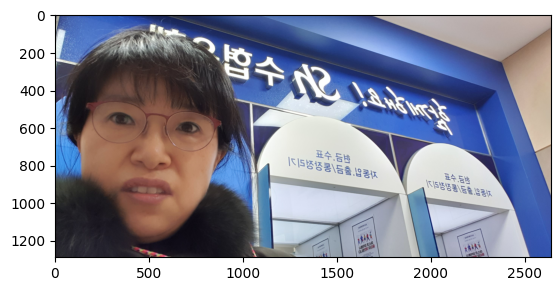

In [71]:
image = cv2.imread(TRAIN_IMG_PATH + 'anger/' + anger[2]['filename'])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

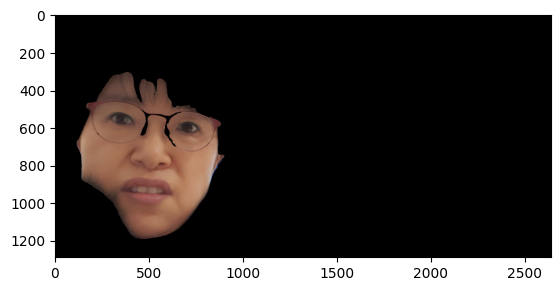

In [55]:
plt.imshow(img_masked)

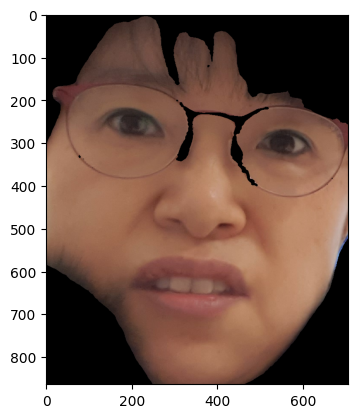

In [56]:
plt.imshow(img_cropped)

In [57]:
img_info

{'filename': 'llfycc0aa29599cc63cace3610fdaaad3a99aab2ee38c9edb6c10966765bbwd5f.jpg',
 'bounding_box': [24, 0, 696, 837],
 'keypoints': {'left_eye': (232, 271),
  'right_eye': (539, 311),
  'nose': (360, 469),
  'mouth_left': (221, 626),
  'mouth_right': (461, 652)}}

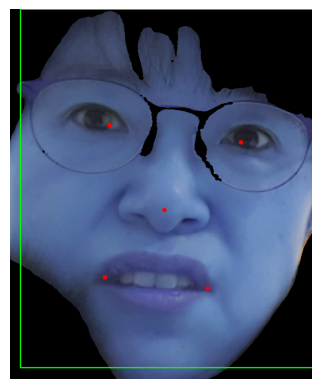

In [58]:
print_face_info(img_cropped, img_info)

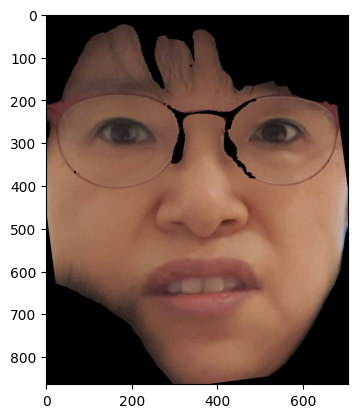

In [69]:
plt.imshow(rotated_image)

In [68]:
img_info

{'filename': 'llfycc0aa29599cc63cace3610fdaaad3a99aab2ee38c9edb6c10966765bbwd5f.jpg',
 'bounding_box': [24, 0, 696, 837],
 'keypoints': {'left_eye': (253, 256),
  'right_eye': (553, 336),
  'nose': (355, 469),
  'mouth_left': (197, 607),
  'mouth_right': (431, 664)}}

### Train Data Preprocessing Pipeline

In [73]:
def train_data_preprocessing_pipeline(path, segment_data, label_data, length):
  img_feature = []

  for i in range(length):
    img_masked = mask_img(label_data[i]['filename'], path, segment_data) # 이미지 face만 출력
    img_cropped = crop_face(label_data[i],img_masked) # 이미지 Crop
    img_info = extract_face_info(label_data[i], img_cropped) # 이미지 특징점 추출
    rotated_image = rotate_image(img_cropped, calculate_angle(img_info)) # 좌/우 눈을 수평으로 이미지 회전
    img_info['keypoints'] = rotate_keypoints(img_info['keypoints'], calculate_angle(img_info), (img_cropped.shape[1] // 2, img_cropped.shape[0] // 2)) # 키포인트 회전, 기존 키포인트 수정
    img_feature.append(img_info) # 수정된 이미지 특징점을 리스트에 추가
    cv2.imwrite(AFTER_PREPROCESSING_IMG_PATH + path + label_data[i]['filename'], rotated_image) # 전처리된 이미지를 Export

  return img_feature

In [75]:
anger_img_info = train_data_preprocessing_pipeline('anger/', anger_segment, anger, 5)
happy_img_info = train_data_preprocessing_pipeline('happy/', happy_segment, happy, 5)
panic_img_info = train_data_preprocessing_pipeline('panic/', panic_segment, panic, 5)
sadness_img_info = train_data_preprocessing_pipeline('sadness/', sadness_segment, sadness, 5)

1/1 [==============================] - 0s 161ms/step


In [79]:
sadness_img_info[1]

{'filename': 'plxg3fd368ea807fe7d76d986ed20c53d1db0d623c2603f0bd20b6dbf7bb2ohxl.jpg',
 'bounding_box': [0, 4, 358, 467],
 'keypoints': {'left_eye': (81, 195),
  'right_eye': (247, 189),
  'nose': (160, 286),
  'mouth_left': (110, 379),
  'mouth_right': (233, 376)}}